In [5]:
import re, string, unicodedata
import numpy as np
import pandas as pd

pd.set_option('display.max_colwidth', 40)

In [6]:
import contractions
import nltk
from datetime import datetime
from matplotlib import pyplot as plt

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

import re, string, unicodedata
import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_val_score

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\javier\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\javier\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\javier\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\javier\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Perfilamiento y entendimiento de datos

## 1. Lectura de datos

In [7]:
train_set = "fake_news_spanish.csv"
df = pd.read_csv(train_set, sep=';', encoding='utf-8')

print(df.shape)
df.head(3)

(57063, 5)


,ID,Label,Titulo,Descripcion,Fecha
0,ID,1,'The Guardian' va con Sánchez: 'Euro...,El diario británico publicó este pas...,02/06/2023
1,ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA L...,REVELAN QUE EL GOBIERNO NEGOCIO LA L...,01/10/2023
2,ID,1,El 'Ahora o nunca' de Joan Fuster so...,El valencianismo convoca en Castelló...,25/04/2022


## 2. Entendimiento de datos

Debido a que el proyecto no contaba con un diccionario de datos se opto por desarrollar uno propio para la entrega. En este diccionario de datos se detalla lo siguiente:

| Columna | Descripción |
| - | - |
| `ID` | Se tiene el identificador del registro, sin embargo, todos los registros tienen la cadena ID. |
| `Label` | Es la etiqueta del registro; 1 si el registro es una noticia falsa, 0 de lo contrario.  |
| `Titulo` | Corresponde al titulo de la noticia. |
| `Descripcion` | Corresponde a la descripción o el cuerpo de la noticia. |
| `Fecha` | Es la fecha en la que se publico la noticia. |

In [8]:
df.dtypes

ID             object
Label           int64
Titulo         object
Descripcion    object
Fecha          object
dtype: object

In [9]:
df.head()

,ID,Label,Titulo,Descripcion,Fecha
0,ID,1,'The Guardian' va con Sánchez: 'Euro...,El diario británico publicó este pas...,02/06/2023
1,ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA L...,REVELAN QUE EL GOBIERNO NEGOCIO LA L...,01/10/2023
2,ID,1,El 'Ahora o nunca' de Joan Fuster so...,El valencianismo convoca en Castelló...,25/04/2022
3,ID,1,"Iglesias alienta a Yolanda Díaz, ERC...","En política, igual que hay que negoc...",03/01/2022
4,ID,0,Puigdemont: 'No sería ninguna traged...,"En una entrevista en El Punt Avui, e...",09/03/2018


Al revisar la distribución de noticias catalogadas como falsas y no falsas notamos que este sigue una buena distribución, es decir, se tiene buena cantidad de ambas clases de noticias. Cerca del 60% de los registros son noticias falsas, mientras que aproximadamente el 40% de no lo son. 

In [10]:
df["Label"].value_counts() / df.shape[0] * 100

Label
1    58.107706
0    41.892294
Name: count, dtype: float64

Se calculan las siguientes columnas para intentar hallar una relación entre estos estadisticos y las noticias falsas.

In [11]:
copy = df.copy()

copy["Count"] = [len(text) for text in copy["Descripcion"]] # Cantidad de caracteres en el registro
copy["Max"] = [max([len(word) for word in text.split(' ')]) for text in copy["Descripcion"] ] # Longitud de la palabra mas larga en el registro
copy["Min"] = [min([len(word) for word in text.split(' ')]) for text in copy["Descripcion"] ] # Longitud de la palabra mas corta en el registro
copy["Mean"] = [np.mean([len(word) for word in text.split(' ')]) for text in copy["Descripcion"] ] # Promedio de longitud de la palabra en el registro

copy.head(3)

,ID,Label,Titulo,Descripcion,Fecha,Count,Max,Min,Mean
0,ID,1,'The Guardian' va con Sánchez: 'Euro...,El diario británico publicó este pas...,02/06/2023,218,13,1,5.083333
1,ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA L...,REVELAN QUE EL GOBIERNO NEGOCIO LA L...,01/10/2023,3251,17,1,5.067164
2,ID,1,El 'Ahora o nunca' de Joan Fuster so...,El valencianismo convoca en Castelló...,25/04/2022,169,13,2,4.666667


Al realizar un análisis de los estadisticos de las noticias falsas y las que no lo son tal parece que no hay grandes diferencias entre una u otra. Por ejemplo, la media de caracteres en las noticias falsas difiera de tan solo 7 unidades de las noticias que no lo son, 240 y 247 respectivamente. Los otros estadisticos continuan con esta tendencia.

In [12]:
copy[copy["Label"] == 1][["Count", "Max", "Min"]].describe()

,Count,Max,Min
count,33158.000000,33158.000000,33158.000000
mean,240.385729,12.708245,1.171965
std,301.279710,2.102463,0.384403
min,33.000000,6.000000,0.000000
25%,169.000000,11.000000,1.000000
50%,218.000000,13.000000,1.000000
75%,257.000000,14.000000,1.000000
max,14019.000000,38.000000,3.000000


In [13]:
copy[copy["Label"] == 0][["Count", "Max", "Min"]].describe()

,Count,Max,Min
count,23905.000000,23905.000000,23905.000000
mean,247.697260,12.717005,1.156662
std,228.702697,2.151326,0.383756
min,35.000000,6.000000,0.000000
25%,176.000000,11.000000,1.000000
50%,226.000000,13.000000,1.000000
75%,278.000000,14.000000,1.000000
max,13647.000000,69.000000,3.000000


### 2.1 Calidad de datos

### 2.1.1 Unicidad

In [14]:
copy = df.copy()

copy[copy.duplicated()].shape

(445, 5)

In [15]:
copy.drop_duplicates(keep='first', inplace=True)
copy.head(2)

,ID,Label,Titulo,Descripcion,Fecha
0,ID,1,'The Guardian' va con Sánchez: 'Euro...,El diario británico publicó este pas...,02/06/2023
1,ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA L...,REVELAN QUE EL GOBIERNO NEGOCIO LA L...,01/10/2023


Al revisar los titulos y las descripciones duplicadas por separado obtenemos que hay cerca 5000 titulos duplicados y cerca de 7000 descripciones duplicadas. En los siguientes dos bloques de código se realiza un análisis de la distribución de las etiquetas, lo que nos lleva a concluir que las noticias duplicadas no tienden a ser mas falsas que las que no. Por otro lado, no es tan raro pensar en noticias con titulos duplicados, por tanto, se opta por dejar estas. Lo cual no lleva a centrar nuestra atención es las noticias con descripciones iguales. 

In [16]:
copy[copy.duplicated('Titulo')]["Label"].value_counts()

Label
0    2596
1    2417
Name: count, dtype: int64

In [17]:
copy[copy.duplicated('Descripcion')]["Label"].value_counts()

Label
0    3603
1    3377
Name: count, dtype: int64

En cuanto a las noticias con descripciones duplicadas se opta por eliminarlas del dataset. 

In [18]:
copy.drop_duplicates('Descripcion', keep='first', inplace=True)
copy.shape

(49638, 5)

### 2.1.2 Completitud

In [19]:
copy.isna().sum()

ID              0
Label           0
Titulo         16
Descripcion     0
Fecha           0
dtype: int64

In [20]:
# Reemplazar los NaN con la primera frase de la descripcion
copy \
    .loc[copy["Titulo"].isna(), "Titulo"] = copy["Descripcion"] \
    .apply(lambda t: t.strip().split(".")[0] if isinstance(t, str) else t)

copy.isna().sum()

ID             0
Label          0
Titulo         0
Descripcion    0
Fecha          0
dtype: int64

### 2.1.3 Validez

TODO: AÑADIR DESCRIPCIÓN DE QUE SE HACE.

In [21]:
copy["formated_date"] = pd.to_datetime(copy["Fecha"], format="%d/%m/%Y", errors="coerce")

copy.isna().sum()

ID               0
Label            0
Titulo           0
Descripcion      0
Fecha            0
formated_date    0
dtype: int64

En la columna Label solo debe haber `0` o `1`, esto se verifica en la siguiente celda.

In [22]:
copy["Label"].value_counts()

Label
1    29361
0    20277
Name: count, dtype: int64

Se realiza un análisis de todos los titulos para comprobar si una de las palabras mas usadas en ingles se incluye en el titulo. Al realizar la transformación se obtiene que hay 37 registros con esta palabra y al revisar mas detalladamente se llega a la conclusión de que las noticias pueden tener palabras en ingles, pero en su totalidad el dataset no tiene la palabra en ingles "The", indicando la posibilidad de que este sea completamente en español. Nos quedaremos con este supuesto por facilidad. 

In [23]:
def detectar_idioma(texto):
    words = ["The", "The ", " the "]
    for word in words:
        if word in texto:
            return "unk"
    return "es"

copy["Idioma"] = copy["Titulo"].apply(detectar_idioma)

In [24]:
print(copy["Idioma"].value_counts())

Idioma
es     49601
unk       37
Name: count, dtype: int64


In [25]:
copy[copy["Idioma"] == 'unk'].head(37)

,ID,Label,Titulo,Descripcion,Fecha,formated_date,Idioma
0,ID,1,'The Guardian' va con Sánchez: 'Euro...,El diario británico publicó este pas...,02/06/2023,2023-06-02,unk
308,ID,1,La Guardia Civil incluye un 'off the...,El instituto armado se hace eco de l...,04/06/2020,2020-06-04,unk
1752,ID,1,Yolanda Díaz 'on the highway',"Bien podría ser una metáfora, bien p...",23/07/2022,2022-07-23,unk
3038,ID,1,'The New York Times' da voz a quiene...,Un reportaje refleja el descontento ...,08/04/2019,2019-04-08,unk
4281,ID,1,La revista 'The Lancet' señala que l...,El editorial de la prestigiosa revis...,17/10/2020,2020-10-17,unk
4628,ID,0,Así habla 'The Times' sobre Elías Be...,El diario británico critica el progr...,07/06/2023,2023-06-07,unk
6253,ID,1,'The New York Times' alerta sobre la...,El diario norteamericano asegura que...,07/12/2018,2018-12-07,unk
7673,ID,1,El periódico 'The New York Times' cr...,La periodista explica que Vox y el P...,20/12/2021,2021-12-20,unk
10261,ID,0,"'The New York Times', sobre Alfonso ...",El chico ha cubierto ya todo el arco...,29/06/2019,2019-06-29,unk
13076,ID,1,Theresa May enfrenta una gran derrot...,Tenemos la oportunidad de irnos el 2...,10/03/2019,2019-03-10,unk


### 2.1.4 Consistencia

Se debe verificar que no tengamos noticias mayores al día de hoy, lo cual es cierto.

In [26]:
today = datetime.today()
copy[copy["formated_date"] > today].shape

(0, 7)

En el siguiente codigo se verifica si para una misma descripción se cuentan con mas de dos labels diferentes, esto para evitar inconsistencias.  

In [27]:
label_conflicto = copy.groupby("Descripcion")["Label"].nunique()
print(label_conflicto[label_conflicto > 1])

Series([], Name: Label, dtype: int64)


# 3. Preparación de datos

En esta fase se hará un proceso de tres etapas:

1. Limpieza de datos
2. Tokenización
3. Normalización

## 3.1 Limpieza de datos

In [28]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        if word is not None:
          new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
          new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    return [word.lower() for word in words]

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        if word is not None:
            new_word = re.sub(r'[^\w\s]', '', word)
            if new_word != '':
                new_words.append(new_word)
    return new_words

def replace_numbers(words):
   """Replace all interger occurrences in list of tokenized words with textual representation"""
   p = inflect.engine()
   new_words = []
   for word in words:
       if word.isdigit():
           new_word = p.number_to_words(word)
           new_words.append(new_word)
           #print("if " + new_word)
       else:
           new_words.append(word)
   return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    stop_words = set(stopwords.words('spanish'))  # Cargar stopwords en español
    return [word for word in words if word not in stop_words]

def preprocessing(words):
    words = to_lowercase(words)
    words = replace_numbers(words)
    words = remove_punctuation(words)
    words = remove_non_ascii(words)
    words = remove_stopwords(words)
    return words

## 3.2 Tokenización

En este punto solo es necesario 

In [29]:
#copy['Titulo'] = copy['Titulo'].apply(contractions.fix) No necesario, en español hay solo 2 contracciones
def expand_spanish_contractions(text):
    text = text.replace("al", "a el")
    return text.replace("del" ,"de el")

copy['Descripcion'] = copy['Descripcion'].apply(expand_spanish_contractions)
copy['Titulo'] = copy['Titulo'].apply(expand_spanish_contractions)

copy[['Descripcion', 'Titulo']].head(2)

,Descripcion,Titulo
0,El diario británico publicó este pas...,'The Guardian' va con Sánchez: 'Euro...
1,REVELAN QUE EL GOBIERNO NEGOCIO LA L...,REVELAN QUE EL GOBIERNO NEGOCIO LA L...


In [30]:
copy['tokenized_desc'] = copy['Descripcion'].apply(word_tokenize)
copy['tokenized_titl'] = copy['Titulo'].apply(word_tokenize)

copy[['tokenized_desc', 'tokenized_titl']].head(3)

,tokenized_desc,tokenized_titl
0,"[El, diario, británico, publicó, est...","['The, Guardian, ', va, con, Sánchez..."
1,"[REVELAN, QUE, EL, GOBIERNO, NEGOCIO...","[REVELAN, QUE, EL, GOBIERNO, NEGOCIO..."
2,"[El, va, elencianismo, convoca, en, ...","[El, 'Ahora, o, nunca, ', de, Joan, ..."


In [31]:
# aplica la eliminación del ruido
copy['tokenized_desc'] = copy['tokenized_desc'].apply(preprocessing)
copy['tokenized_titl'] = copy['tokenized_titl'].apply(preprocessing)

copy[['tokenized_desc', 'tokenized_titl']].head(3)

,tokenized_desc,tokenized_titl
0,"[diario, britanico, publico, pasado,...","[the, guardian, va, sanchez, europa,..."
1,"[revelan, gobierno, negocio, liberac...","[revelan, gobierno, negocio, liberac..."
2,"[va, elencianismo, convoca, castello...","[ahora, nunca, joan, fuster, estatut..."


## 3.3 Normalización

TODO: Solo funciona para ingles. El LancasterStemmer() hace reducciones agresivas que pueden provocar que se pierdan algunas palabras. Código sugerido por chat.

```python
import spacy
import nltk
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize

# Descargar modelo de español para Spacy
try:
    nlp = spacy.load("es_core_news_sm")
except OSError:
    import spacy.cli
    spacy.cli.download("es_core_news_sm")
    nlp = spacy.load("es_core_news_sm")

stemmer = SnowballStemmer('spanish')

def stem_words(words):
    """Aplica stemming en español"""
    return [stemmer.stem(word) for word in words]

def lemmatize_words(words):
    """Aplica lematización con Spacy en español"""
    doc = nlp(' '.join(words))
    return [token.lemma_ for token in doc]

def stem_and_lemmatize(words):
    stems = stem_words(words)
    lemmas = lemmatize_words(words)
    return stems + lemmas

copy['tokenized_desc'] = copy['tokenized_desc'].apply(stem_and_lemmatize)
copy.head()
```

In [32]:
stemmer = LancasterStemmer()
lemmatizer = WordNetLemmatizer()

def stem_words(words):
    """Stem words in list of tokenized words"""
    return [stemmer.stem(word) for word in words]

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    return [lemmatizer.lemmatize(word, pos='v') for word in words]

def stem_and_lemmatize(words):
    stems = stem_words(words)
    lemmas = lemmatize_verbs(words)
    return stems + lemmas

# Aplica lematización y Eliminación de Prefijos y Sufijos.
copy['normalized_desc'] = copy['tokenized_desc'].apply(stem_and_lemmatize)
copy['normalized_titl'] = copy['tokenized_titl'].apply(stem_and_lemmatize)

In [33]:
copy[['normalized_desc', 'tokenized_desc', 'normalized_titl', 'tokenized_titl']].head(5)

,normalized_desc,tokenized_desc,normalized_titl,tokenized_titl
0,"[diario, britanico, publico, pasado,...","[diario, britanico, publico, pasado,...","[the, guard, va, sanchez, europ, nec...","[the, guardian, va, sanchez, europa,..."
1,"[revel, gobierno, negocio, liberac, ...","[revelan, gobierno, negocio, liberac...","[revel, gobierno, negocio, liberac, ...","[revelan, gobierno, negocio, liberac..."
2,"[va, elencianismo, convoc, castello,...","[va, elencianismo, convoca, castello...","[ahor, nunc, joan, fust, estatuto, v...","[ahora, nunca, joan, fuster, estatut..."
3,"[politic, igu, negoci, empresario, n...","[politica, igua, negociar, empresari...","[iglesia, elient, yoland, diaz, erc,...","[iglesias, elienta, yolanda, diaz, e..."
4,"[entrevist, punt, avu, lid, jxcat, d...","[entrevista, punt, avui, lider, jxca...","[puigdemont, ser, ningun, traged, re...","[puigdemont, seria, ninguna, tragedi..."


## 3.4 Selección de campos

TODO: Añadir explicación breve.

In [34]:
copy['desc_words'] = copy['normalized_desc'].apply(lambda x: ' '.join(map(str, x)))
copy['titl_words'] = copy['normalized_titl'].apply(lambda x: ' '.join(map(str, x)))

In [35]:
copy[['desc_words', 'normalized_desc', 'titl_words', 'normalized_titl']].head(3)

,desc_words,normalized_desc,titl_words,normalized_titl
0,diario britanico publico pasado juev...,"[diario, britanico, publico, pasado,...",the guard va sanchez europ necesit a...,"[the, guard, va, sanchez, europ, nec..."
1,revel gobierno negocio liberac mirel...,"[revel, gobierno, negocio, liberac, ...",revel gobierno negocio liberac mirel...,"[revel, gobierno, negocio, liberac, ..."
2,va elencianismo convoc castello fies...,"[va, elencianismo, convoc, castello,...",ahor nunc joan fust estatuto va elen...,"[ahor, nunc, joan, fust, estatuto, v..."


In [37]:
X_data, y_label = copy[['desc_words', 'titl_words']], copy['Label']
print(X_data.shape, y_label.shape)

(49638, 2) (49638,)


In [38]:
tf_idf = TfidfVectorizer()

X_data.loc[:, 'combined'] = X_data['desc_words'] + ' ' + X_data['titl_words']

X_tf_idf = tf_idf.fit_transform(X_data['combined'])

C:\Users\javier\AppData\Local\Temp\ipykernel_12024\2066480332.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_data.loc[:, 'combined'] = X_data['desc_words'] + ' ' + X_data['titl_words']


In [39]:
X_tf_idf.toarray().shape

(49638, 66495)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(
    X_tf_idf,
    y_label,
    test_size=0.3,
    random_state=42
)

In [41]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [46]:
scores = cross_val_score(model, X_test, y_test, cv=5, scoring='f1')

scores.mean()

0.9054642355330793

In [43]:
y_pred = model.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.79      0.86      6128
           1       0.87      0.97      0.92      8764

    accuracy                           0.90     14892
   macro avg       0.91      0.88      0.89     14892
weighted avg       0.90      0.90      0.90     14892



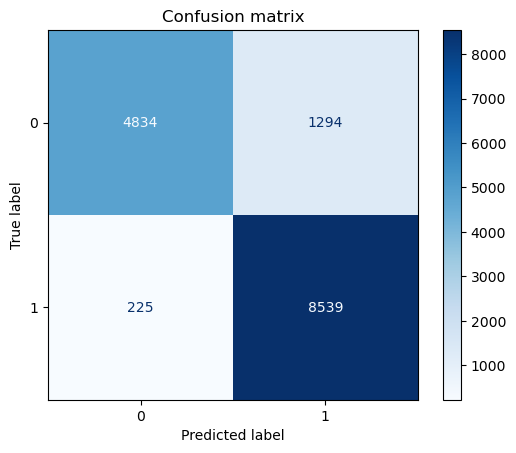

In [44]:
disp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred),
    display_labels=[0, 1]
)

disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.show()